In [43]:
from sklearn.metrics import classification_report
import torch.optim as optim
import torch.nn as nn
from nn import (
    Linear, ReLU, Softmax, Flatten,
    Sequential, CrossEntropyLoss, Adam, Net
)
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import sys
import os

In [44]:
def plot_training_history(train_losses, val_accuracies, save_path=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', linewidth=2, marker='o', markersize=4, label='Training Loss')
    ax1.set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)

    ax2.plot(epochs, val_accuracies, 'r-', linewidth=2, marker='s', markersize=4, label='Validation Accuracy')
    ax2.set_title('Validation Accuracy Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [45]:
def plot_combined_metrics(train_losses, val_accuracies, save_path=None):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    epochs = range(1, len(train_losses) + 1)

    color = 'tab:blue'
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Training Loss', color=color, fontsize=12)
    line1 = ax1.plot(epochs, train_losses, color=color, linewidth=2,
                     marker='o', markersize=4, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Validation Accuracy', color=color, fontsize=12)
    line2 = ax2.plot(epochs, val_accuracies, color=color, linewidth=2,
                     marker='s', markersize=4, label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.set_title('Training Progress: Loss vs Accuracy', fontsize=14, fontweight='bold')

    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [46]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, save_path=None):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    if class_names is None:
        class_names = [str(i) for i in range(10)]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})

    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)

    accuracy = np.trace(cm) / np.sum(cm)
    plt.figtext(0.02, 0.02, f'Overall Accuracy: {accuracy:.4f}',
                fontsize=12, fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    return cm

In [47]:
def plot_prediction_distribution(y_true, y_pred, save_path=None):
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.ravel()

    for i in range(10):
        true_class_mask = (y_true == i)
        pred_for_class = y_pred[true_class_mask]

        unique, counts = np.unique(pred_for_class, return_counts=True)

        axes[i].bar(unique, counts, alpha=0.7, color=plt.cm.tab10(i))
        axes[i].set_title(f'True Class {i}', fontweight='bold')
        axes[i].set_xlabel('Predicted Class')
        axes[i].set_ylabel('Count')
        axes[i].set_xticks(range(10))
        axes[i].grid(True, alpha=0.3)

        if i in unique:
            idx = np.where(unique == i)[0][0]
            axes[i].bar(unique[idx], counts[idx], alpha=1.0, color='green')

    plt.suptitle('Prediction Distribution by True Class', fontsize=16, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [48]:
def plot_gradient_norms(gradient_norms_history, save_path=None):
    if not gradient_norms_history:
        print("No gradient norms to plot")
        return

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.ravel()

    layer_names = ['First Layer Weight', 'First Layer Bias', 'Second Layer Weight',
                   'Second Layer Bias', 'Output Layer Weight', 'Output Layer Bias']

    epochs = range(1, len(gradient_norms_history) + 1)

    for i, layer_name in enumerate(layer_names):
        if i < len(axes):
            norms = [epoch_norms[i] for epoch_norms in gradient_norms_history]
            axes[i].plot(epochs, norms, linewidth=2, marker='o', markersize=4)
            axes[i].set_title(f'{layer_name} Gradient Norm', fontweight='bold')
            axes[i].set_xlabel('Epoch')
            axes[i].set_ylabel('Gradient Norm')
            axes[i].grid(True, alpha=0.3)

    plt.suptitle('Gradient Norms During Training', fontsize=16, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [49]:
def plot_sample_predictions(net, validation_loader, num_samples=12, save_path=None):
    net.eval()

    dataiter = iter(validation_loader)
    images, labels = next(dataiter)

    with torch.no_grad():
        outputs = net.forward(images)
        predictions = torch.argmax(outputs, dim=1)

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.ravel()

    for i in range(min(num_samples, len(images))):
        img = images[i].squeeze()
        img = img / 2 + 0.5

        axes[i].imshow(img.numpy(), cmap='gray')

        true_label = labels[i].item()
        pred_label = predictions[i].item()
        confidence = torch.max(outputs[i]).item()

        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.3f}',
                          color=color, fontweight='bold')
        axes[i].axis('off')

    plt.suptitle('Sample Predictions', fontsize=16, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [50]:
def show_image(img: torch.Tensor):
    img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")

In [51]:
def train_one_epoch(net, training_loader, optimizer, loss_fn, epoch, collect_gradients=False):
    total_loss = 0
    gradient_norms = []

    for i, data in enumerate(training_loader):
        inputs, labels = data

        outputs = net.forward(inputs)

        loss = loss_fn.forward(outputs, labels)

        loss_grad = loss_fn.backward()
        net.backward(loss_grad)

        gradients = net.get_gradients()

        if collect_gradients:
            batch_grad_norms = []
            for grad in gradients:
                if grad is not None:
                    batch_grad_norms.append(torch.norm(grad).item())
                else:
                    batch_grad_norms.append(0.0)
            gradient_norms.append(batch_grad_norms)

        optimizer.step(gradients)

        total_loss += loss.item()

    avg_gradient_norms = None
    if collect_gradients and gradient_norms:
        avg_gradient_norms = np.mean(gradient_norms, axis=0).tolist()

    return total_loss / len(training_loader), avg_gradient_norms

In [52]:
def evaluate_model(net, validation_loader, return_predictions=False):
    net.eval()
    preds = []
    gts = []

    for i, data in enumerate(validation_loader):
        inputs, labels = data
        outputs = net.forward(inputs)
        outputs = torch.argmax(outputs, dim=-1)

        gts += labels.tolist()
        preds += outputs.tolist()

    acc = torch.sum(
        torch.tensor(gts) == torch.tensor(preds)
    ) / len(gts)

    if return_predictions:
        return acc.item(), np.array(gts), np.array(preds)
    else:
        return acc.item()

In [53]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print("Loading MNIST dataset...")
training_set = torchvision.datasets.MNIST(
    './data',
    train=True,
    transform=transform,
    download=True
)

validation_set = torchvision.datasets.MNIST(
    './data',
    train=False,
    transform=transform,
    download=True
)

print(f"Training set size: {len(training_set)}")
print(f"Validation set size: {len(validation_set)}")

Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.16MB/s]

100%|██████████| 28.9k/28.9k [00:00<00:00, 102kB/s]

100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]

100%|██████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]

Training set size: 60000
Validation set size: 10000


In [54]:
training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=64,
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=64,
    shuffle=False
)

Displaying sample images...
Sample labels: [7, 7, 8, 2, 9, 2, 2, 5, 1, 9]


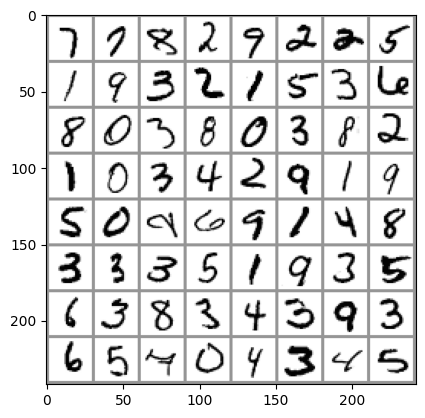

In [55]:
print("Displaying sample images...")
dataiter = iter(training_loader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images)
show_image(img_grid)
print("Sample labels:", labels[:10].tolist())
plt.show()

In [56]:
print("Initializing model...")
net = Net()
loss_fn = CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.001)

print("Testing model with random input...")
x = torch.randn(1, 1, 28, 28)
net.eval()
probs = net.forward(x)
print("Model output probabilities:", probs[0][:5].tolist(), "...")

Initializing model...
Testing model with random input...
Model output probabilities: [0.002226096810773015, 0.010100645944476128, 0.19955243170261383, 0.049307648092508316, 0.025747762992978096] ...


In [57]:
num_epochs = 30
best_acc = 0

train_losses = []
val_accuracies = []
gradient_norms_history = []

checkpoint_dir = './model_checkpoints'
plots_dir = './training_plots'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

In [ ]:
print(f"Starting training for {num_epochs} epochs with neural network...")
print("Plots will be saved in:", plots_dir)
print("Checkpoints will be saved in:", checkpoint_dir)
print("-" * 59)

import time
training_start_time = time.time()
print(f"Training started at: {time.strftime('%H:%M:%S')}")

for epoch in range(1, num_epochs + 1):
    net.train()
    train_loss, gradient_norms = train_one_epoch(net, training_loader, optimizer, loss_fn, epoch, collect_gradients=True)

    acc = evaluate_model(net, validation_loader)

    train_losses.append(train_loss)
    val_accuracies.append(acc)
    if gradient_norms is not None:
        gradient_norms_history.append(gradient_norms)

    if acc > best_acc:
        best_acc = acc
        print(f"Epoch {epoch:2d}/{num_epochs}: Train Loss = {train_loss:.4f}, New Best Val Acc = {acc:.4f}")
        
        checkpoint_path = os.path.join(checkpoint_dir, f'best_model_epoch_{epoch}_acc_{acc:.4f}.pth')
        checkpoint = {
            'epoch': epoch,
            'model_state': {
                'first_layer': {
                    'weight': net.first_layer.weight.data.clone(),
                    'bias': net.first_layer.bias.data.clone()
                },
                'second_layer': {
                    'weight': net.second_layer.weight.data.clone(),
                    'bias': net.second_layer.bias.data.clone()
                },
                'output_layer': {
                    'weight': net.output_layer.weight.data.clone(),
                    'bias': net.output_layer.bias.data.clone()
                }
            },
            'optimizer_state': {
                'lr': optimizer.lr
            },
            'train_loss': train_loss,
            'val_acc': acc,
            'best_acc': best_acc,
            'train_losses': train_losses.copy(),
            'val_accuracies': val_accuracies.copy()
        }
        
        torch.save(checkpoint, checkpoint_path)

print("-" * 59)
training_end_time = time.time()
print(f"Training completed at: {time.strftime('%H:%M:%S')}")
print(f"Total training time: {training_end_time - training_start_time:.2f} seconds")
print(f"Best accuracy: {best_acc:.4f}")

Starting training for 30 epochs with neural network...
Plots will be saved in: ./training_plots
Checkpoints will be saved in: ./model_checkpoints
-----------------------------------------------------------
Training started at: 17:04:04
Epoch  1/30: Train Loss = 1.5824, New Best Val Acc = 0.9371
Epoch  1/30: Train Loss = 1.5824, New Best Val Acc = 0.9371
Epoch  2/30: Train Loss = 1.5260, New Best Val Acc = 0.9509
Epoch  2/30: Train Loss = 1.5260, New Best Val Acc = 0.9509
Epoch  4/30: Train Loss = 1.5075, New Best Val Acc = 0.9539
Epoch  4/30: Train Loss = 1.5075, New Best Val Acc = 0.9539
Epoch  5/30: Train Loss = 1.5051, New Best Val Acc = 0.9606
Epoch  5/30: Train Loss = 1.5051, New Best Val Acc = 0.9606
Epoch  8/30: Train Loss = 1.4984, New Best Val Acc = 0.9627
Epoch  8/30: Train Loss = 1.4984, New Best Val Acc = 0.9627
Epoch 10/30: Train Loss = 1.4952, New Best Val Acc = 0.9671
Epoch 10/30: Train Loss = 1.4952, New Best Val Acc = 0.9671
Epoch 11/30: Train Loss = 1.4937, New Best V

In [59]:
def load_checkpoint(checkpoint_path, net, optimizer=None):
    print(f"Loading checkpoint from: {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path)
    
    net.first_layer.weight.data = checkpoint['model_state']['first_layer']['weight']
    net.first_layer.bias.data = checkpoint['model_state']['first_layer']['bias']
    net.second_layer.weight.data = checkpoint['model_state']['second_layer']['weight']
    net.second_layer.bias.data = checkpoint['model_state']['second_layer']['bias']
    net.output_layer.weight.data = checkpoint['model_state']['output_layer']['weight']
    net.output_layer.bias.data = checkpoint['model_state']['output_layer']['bias']
    
    if optimizer is not None and 'optimizer_state' in checkpoint:
        optimizer.lr = checkpoint['optimizer_state']['lr']
    
    print(f"Checkpoint loaded successfully!")
    print(f"Epoch: {checkpoint['epoch']}")
    print(f"Train Loss: {checkpoint['train_loss']:.4f}")
    print(f"Val Accuracy: {checkpoint['val_acc']:.4f}")
    print(f"Best Accuracy: {checkpoint['best_acc']:.4f}")
    
    return checkpoint

def list_checkpoints(checkpoint_dir):
    if not os.path.exists(checkpoint_dir):
        print("No checkpoint directory found.")
        return []
    
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
    checkpoints.sort()
    
    print(f"Available checkpoints in {checkpoint_dir}:")
    for i, ckpt in enumerate(checkpoints, 1):
        print(f"{i}. {ckpt}")
    
    return checkpoints

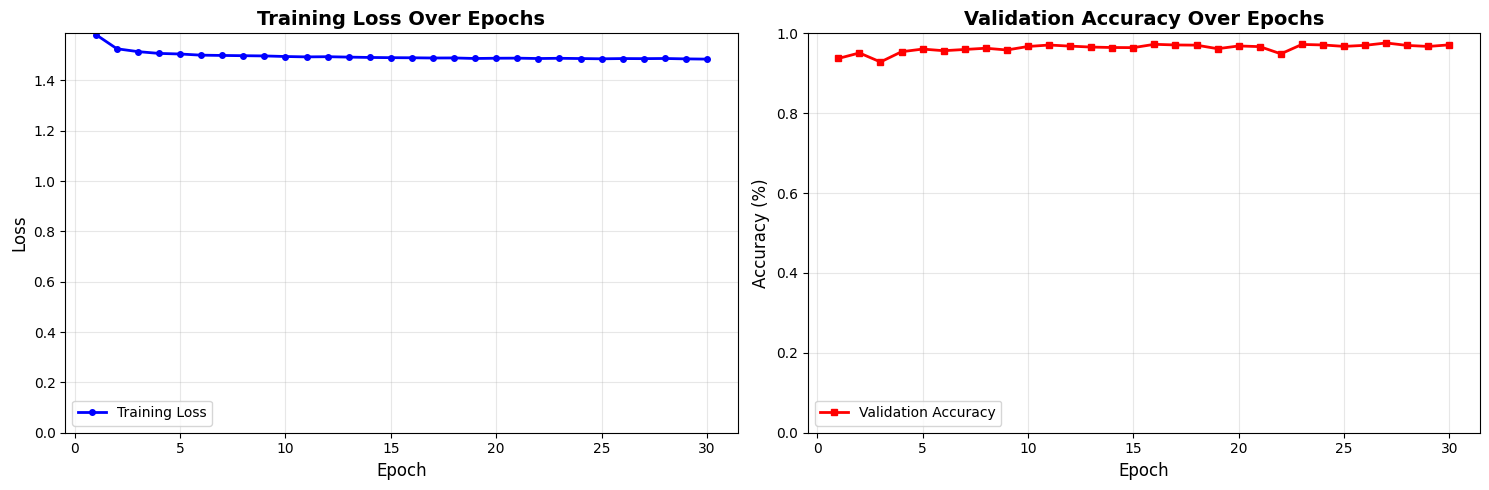

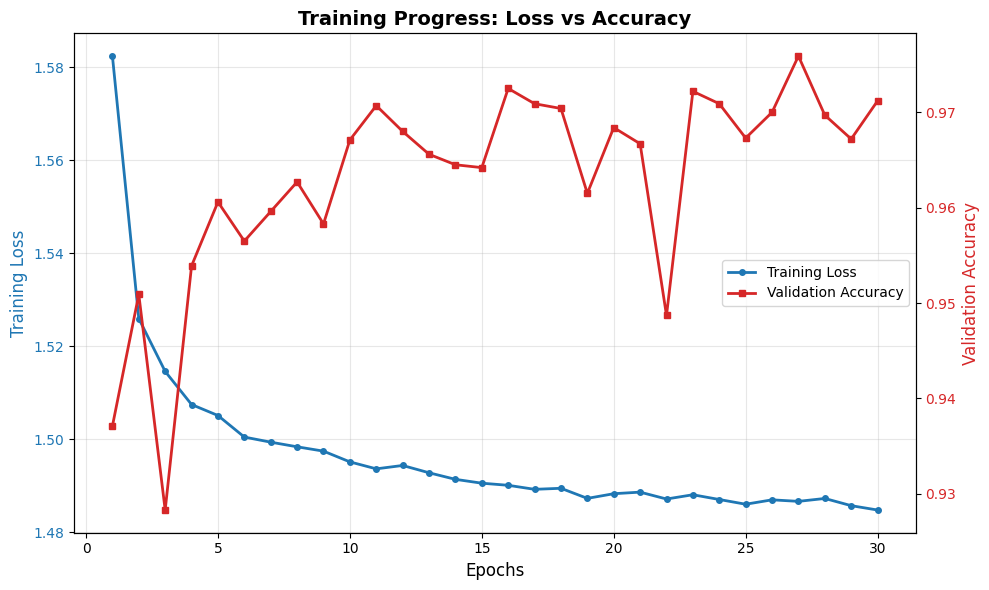

In [60]:
final_acc, y_true, y_pred = evaluate_model(net, validation_loader, return_predictions=True)

plot_training_history(train_losses, val_accuracies,
                      save_path=f'{plots_dir}/final_training_history.png')

plot_combined_metrics(train_losses, val_accuracies,
                      save_path=f'{plots_dir}/final_combined_metrics.png')

Plotting confusion matrix...


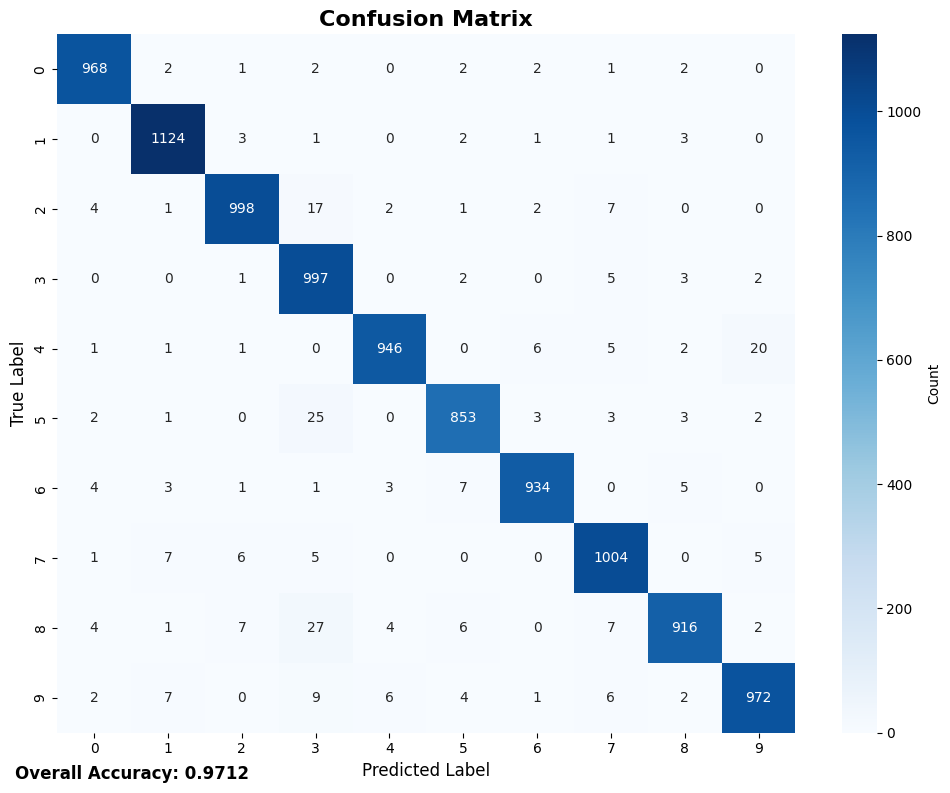

Plotting prediction distribution...


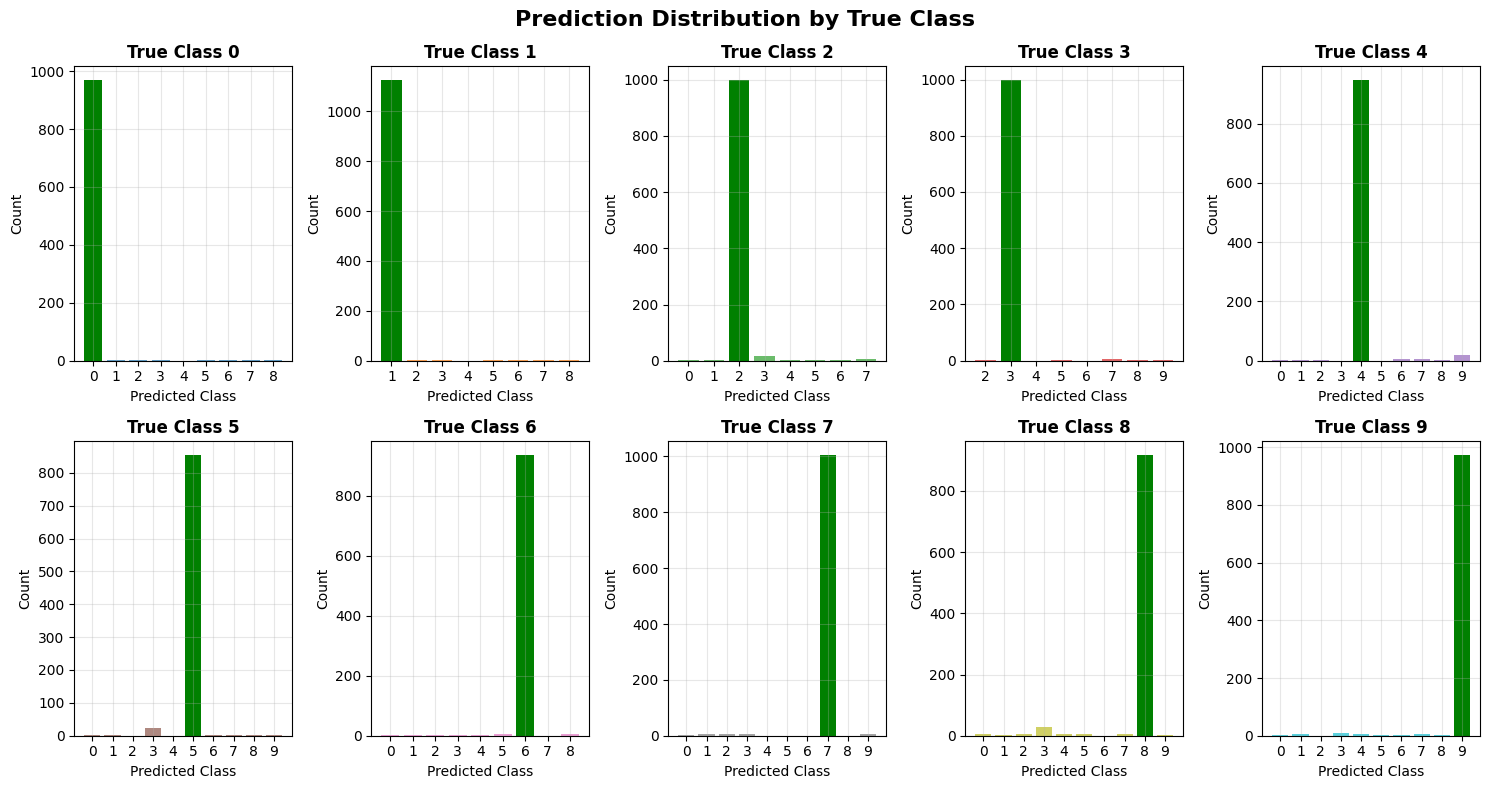

Plotting gradient norms...


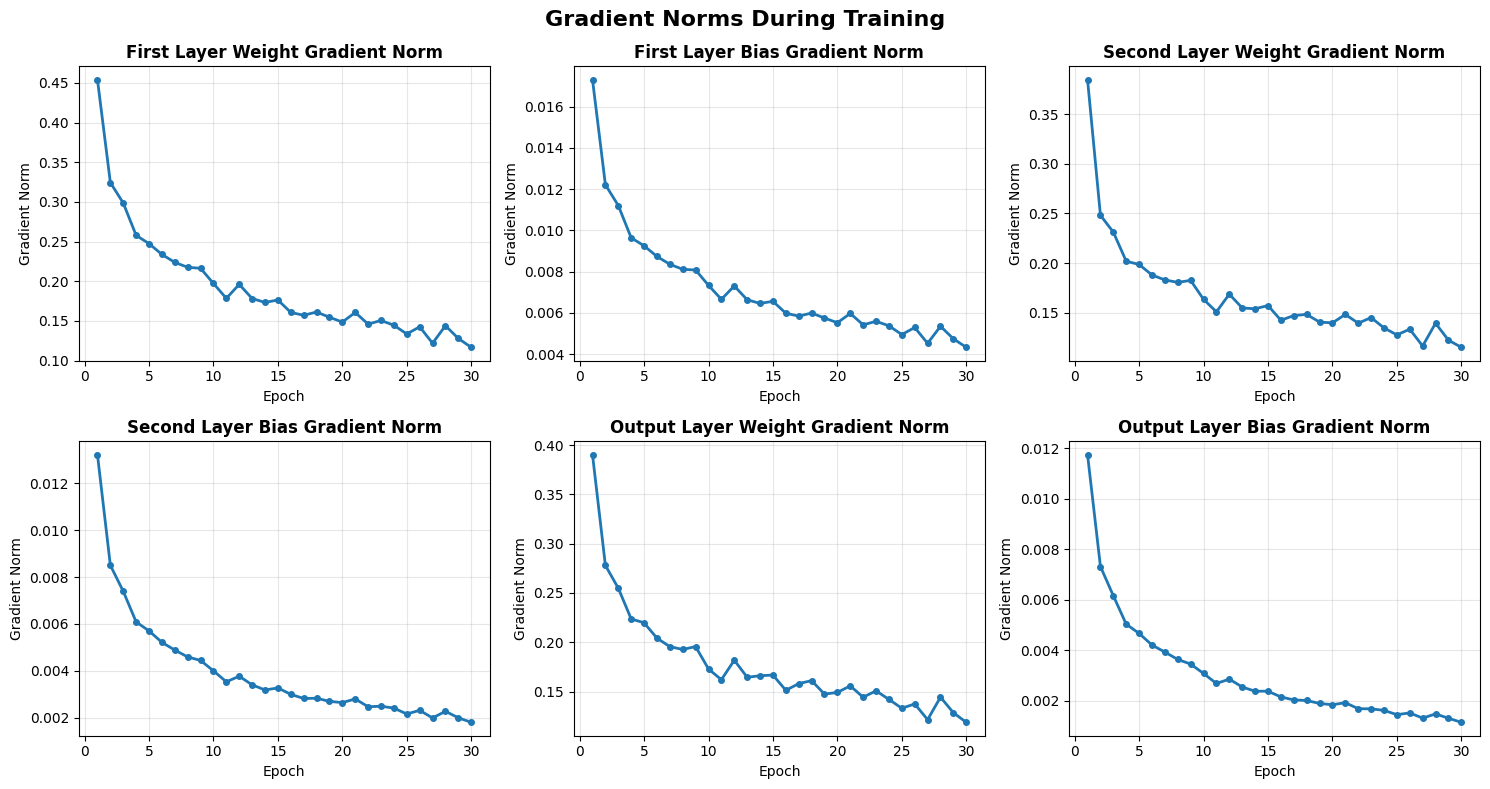

Plotting sample predictions...


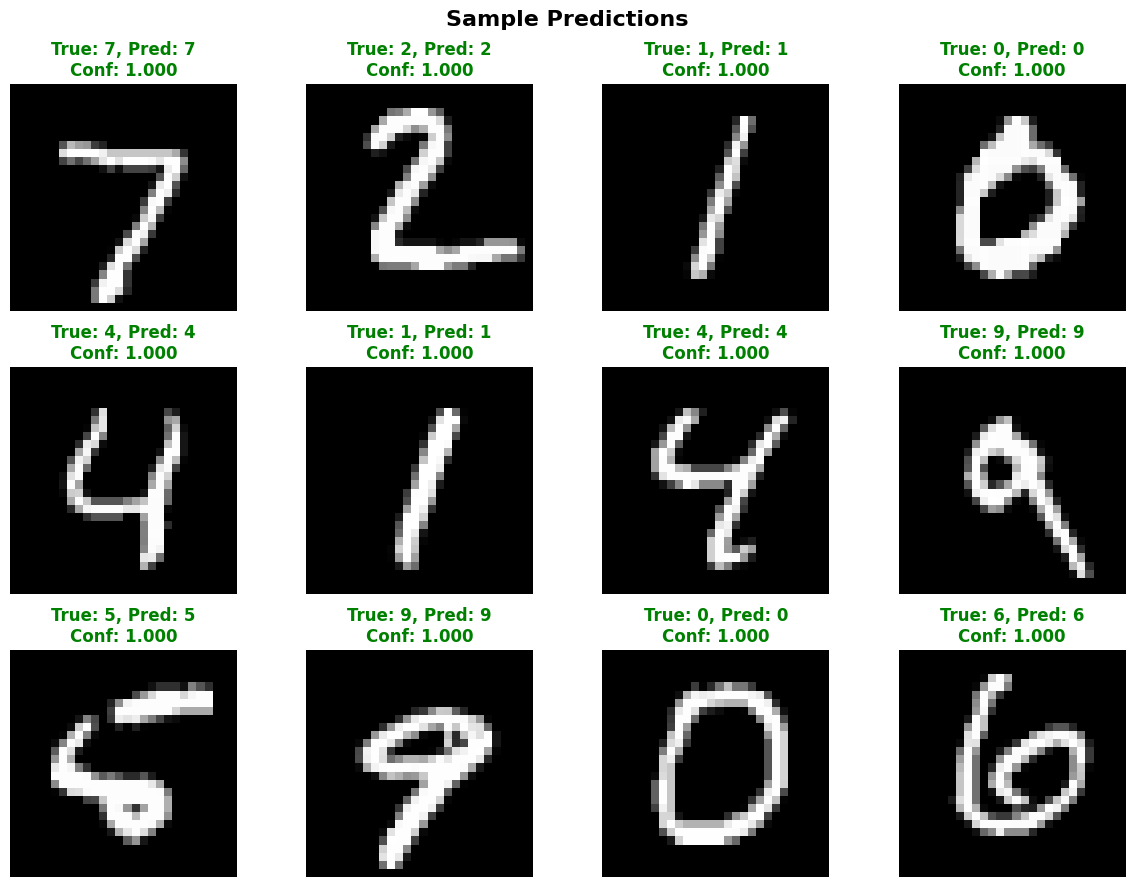

In [61]:
print("Plotting confusion matrix...")
class_names = [str(i) for i in range(10)]
cm = plot_confusion_matrix(y_true, y_pred, class_names=class_names,
                           save_path=f'{plots_dir}/confusion_matrix.png')

print("Plotting prediction distribution...")
plot_prediction_distribution(y_true, y_pred,
                             save_path=f'{plots_dir}/prediction_distribution.png')

if gradient_norms_history:
    print("Plotting gradient norms...")
    plot_gradient_norms(gradient_norms_history,
                        save_path=f'{plots_dir}/final_gradient_norms.png')

print("Plotting sample predictions...")
plot_sample_predictions(net, validation_loader,
                        save_path=f'{plots_dir}/sample_predictions.png')

In [ ]:
print("Detailed Classification Report:")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))

print("Per-class Accuracy:")
print("="*30)
for i in range(10):
    class_mask = (y_true == i)
    if np.sum(class_mask) > 0:
        class_acc = np.sum((y_true == i) & (y_pred == i)) / np.sum(class_mask)
        print(f"Class {i}: {class_acc:.4f} ({np.sum(class_mask)} samples)")

print(f"\nAll plots saved in: {plots_dir}/")
print(f"Final model accuracy: {final_acc:.4f}")

print("="*50)
print("COMPARISON WITH PYTORCH IMPLEMENTATION")
print("="*50)

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.92      0.99      0.95      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.97      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.98      0.94      0.96       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Per-class Accuracy:
Class 0: 0.9878 (980 samples)
Class 1: 0.9903 (1135 samples)
Class 2: 0.9671 (1032 samples)
Class 3: 0.9871 (1010 samples)
Class 4: 0.9633 (982 samples)
Class 5: 0.9563 (892 samples)
Class 

In [63]:
class OriginalNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.first_layer = nn.Linear(784, 256)
        self.first_activation = nn.ReLU()
        self.second_layer = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.output = nn.Sequential(
            nn.Linear(128, 10),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.first_layer(x)
        x = self.first_activation(x)
        x = self.second_layer(x)
        x = self.output(x)
        return x

In [64]:
print("Testing both models with same input...")
test_input = torch.randn(5, 1, 28, 28)

output = net.forward(test_input)
print(f"Model output shape: {output.shape}")
print(f"Model first sample probabilities sum: {torch.sum(output[0]):.4f}")

pytorch_net = OriginalNet()
pytorch_net.eval()
with torch.no_grad():
    pytorch_output = pytorch_net(test_input)
    print(f"PyTorch model output shape: {pytorch_output.shape}")
    print(f"PyTorch model first sample probabilities sum: {torch.sum(pytorch_output[0]):.4f}")

Testing both models with same input...
Model output shape: torch.Size([5, 10])
Model first sample probabilities sum: 1.0000
PyTorch model output shape: torch.Size([5, 10])
PyTorch model first sample probabilities sum: 1.0000


In [65]:
print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)
print(f"Total epochs trained: {num_epochs}")
print(f"Best validation accuracy: {best_acc:.4f}")
print(f"Final validation accuracy: {final_acc:.4f}")
print(f"Total training samples: {len(training_set)}")
print(f"Total validation samples: {len(validation_set)}")
print(f"Plots saved in: {plots_dir}/")
print(f"Model checkpoints in: {checkpoint_dir}/")

print("\nImplementation completed successfully!")
print("Check the training_plots folder for all visualization results!")


TRAINING SUMMARY
Total epochs trained: 30
Best validation accuracy: 0.9759
Final validation accuracy: 0.9712
Total training samples: 60000
Total validation samples: 10000
Plots saved in: ./training_plots/
Model checkpoints in: ./model_checkpoints/

Implementation completed successfully!
Check the training_plots folder for all visualization results!
